In [1]:
import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect

pd.set_option('display.max_columns', None)

engine = db_connect()

# bring in the data ***UPDATED TO STABLIZE OUTPUT****
main_df = pd.read_sql(
    'SELECT * FROM combined_data ORDER BY "NCESSCH", "SURVYEAR"',
    con=engine
)

# function to mark whether a school was operational all five years of data
# creates our 'Currently operational' feature
def mark_always_operational(main_df):

    total_years = main_df['SURVYEAR'].nunique()

    main_df['SY_STATUS_TEXT'] = main_df['SY_STATUS_TEXT'].str.strip()

    operational_counts = (
        main_df[main_df['SY_STATUS_TEXT'] == 'Currently operational']
        .groupby('NCESSCH')['SURVYEAR']
        .nunique()
    )

    always_operational_schools = operational_counts[operational_counts == total_years].index

    main_df['concurrently_operational'] = main_df['NCESSCH'].isin(always_operational_schools)

    return main_df


# apply the function
main_df = mark_always_operational(main_df)  ##UPDATED FROM mark_always_operational(main_df=main_df) --- IGNORE ---

# drop records that were not fully operational across all five years
main_df = main_df[main_df['concurrently_operational'] != False]

# strip whitespace
for col in main_df.select_dtypes(include=["string"]).columns:
    main_df[col] = main_df[col].str.strip()


# begin defining data type conversion processes
# Change columns to floats
float_cols = ["X", "Y", "LATCOD", "LONCOD", "FTE", "STUTERATIO"]

# change columns to int
int_cols = [
    "OBJECTID", "GSLO", "GSHI",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT",
    "PK", "KG", "G01", "G02", "G03", "G04", "G05", "G06",
    "G07", "G08", "G09", "G10", "G11", "G12", "G13",
    "UG", "AE",
    "TOTMENROL", "TOTFENROL", "TOTAL", "MEMBER",
    "AMALM", "AMALF", "AM",
    "ASALM", "ASALF", "AS",
    "BLALM", "BLALF", "BL",
    "HPALM", "HPALF", "HP",
    "HIALM", "HIALF", "HI",
    "TRALM", "TRALF", "TR",
    "WHALM", "WHALF", "WH"
]

# Change columns to strings
string_cols = [
    "NCESSCH", "SURVYEAR", "STABR", "LEAID", "ST_LEAID",
    "LEA_NAME", "SCH_NAME",
    "LSTREET1", "LSTREET2", "LCITY", "LSTATE",
    "LZIP", "LZIP4", "PHONE",
    "VIRTUAL", "SCHOOL_LEVEL", "SCHOOL_TYPE_TEXT",
    "STATUS", "SY_STATUS_TEXT", "ULOCALE", "NMCNTY",
    "CHARTER_TEXT", "LSTREET3", "TITLEI", "STITLEI", "MAGNET_TEXT"
]

# -1 or M -> Indicates that the data are missing.
# -2 or N -> Indicates that the data are not applicable.
# -9 -> Indicates that the data do not meet NCES data quality standards.

# function to clean NCES error codes
def clean_nces_error_codes(main_df, cols):
    error_values = ["M", "-1", "-9", "Missing", -1, -9]
    main_df[cols] = main_df[cols].replace(error_values, np.nan)
    return main_df


# clean ALL columns
cols = float_cols + int_cols + string_cols
main_df = clean_nces_error_codes(main_df, cols)

# convert floats safely
for col in float_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce")

# convert ints safely
for col in int_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce").astype("Int64")

# convert strings
for col in string_cols:
    main_df[col] = main_df[col].astype("string")

# round coordinates
main_df["LATCOD"] = main_df["LATCOD"].round(4)
main_df["LONCOD"] = main_df["LONCOD"].round(4)

# extract start Year - convert to int for sorting
main_df['SURVYEAR'] = main_df['SURVYEAR'].str[:4].astype(int)

# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

# *****MOVED TO HERE AN NOW NO LONGER BREAKS*******
# updating nces error codes to No or 0 for respective columns
values = ["N", "-2", "Not applicable", "Not Applicable", -2]
main_df.loc[main_df['CHARTER_TEXT'].isin(values), 'CHARTER_TEXT'] = 'No'
main_df.loc[main_df['MAGNET_TEXT'].isin(values), 'MAGNET_TEXT'] = 'No'
main_df.loc[main_df['FRELCH'].isin(values), 'FRELCH'] = 0
main_df.loc[main_df['REDLCH'].isin(values), 'REDLCH'] = 0

# replace na values with 0
# main_df = main_df.fillna(0)

# UPDATE: Fill numeric columns ONLY (avoid category corruption)
num_cols = main_df.select_dtypes(include=["number"]).columns
main_df[num_cols] = main_df[num_cols].fillna(0)

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"1. main_df shape: {main_df.shape}")

# Simplify ULOCALE
main_df["locale_category"] = main_df["ULOCALE"].str.split("-").str[1].str.split(":").str[0]

# Drop the ULOCALE feature because we now have our simplified locale_category feature
main_df.drop(columns='ULOCALE', inplace=True)

# Title I rough breakdown:
# Participating:
# 1 - Yes - School participates in Title I funding / programs
# 5 - Title I schoolwide school - ENTIRE school recieves Title I support. Funds can be used for all students
# 2 - Title I targeted assistance school - Only SPECIFIC eligible students recieve services (usually low-income or academically at risk)

# Eligible, but no program running:
# 4 - Title I schoolwide eligible school - no program - Enough low-income students to qualify for schoolwide funding, but not using it
# 1 - Title I targeted assistance eligible school - No program - Eligible for targeted assistance but not participating

# Hybrid
# 3 Title I schoolwide eligible - Title I targeted assitance program - School qualifies for schoolwide funding but has chosen to run only a targeted program

# Explicit non-participation
# 2 - No - School does not participate
# 6 - Not a Title I school

# 0
# 0 - Assuming missing, unknown, or not reported

# Conceptual differences:
# Schoolwide = whole school qualifies = High funding flexibility - Typical poverty threshold >= 40% low-income
# Targeted = only some students qualify = Limited funding flexibility - lower threshold for poverty

# standardize TITLEI
schoolwide = ['1-Yes', '5-Title I schoolwide school']
targeted = ['2-Title I targeted assistance school', '3-Title I schoolwide eligible-Title I targeted assistance program']
elig_no_participate = ['4-Title I schoolwide eligible school-No program',
                       '1-Title I targeted assistance eligible school-No program']
not_elig = ['2-No', '6-Not a Title I school']
missing = [0]


# UPDATE / FIX: handle pandas NA safely
def group_titlei(col_TITLEI):

    # Handle missing values FIRST
    if pd.isna(col_TITLEI):  ##UPDATED added this in
        return "Unknown"

    if col_TITLEI in schoolwide:
        return "Schoolwide"
    elif col_TITLEI in targeted:
        return "Targeted"
    elif col_TITLEI in elig_no_participate:
        return "Eligible_No_Program"
    elif col_TITLEI in not_elig:
        return "Not_Eligible"
    else:
        return "Error"


# apply the above function to main_df
main_df['TITLEI_GROUPED'] = main_df['TITLEI'].apply(group_titlei)

# standardize STITLEI
STITLEI_yes = ['1-Yes', 'Yes']
STITLEI_no = ['2-No', 'No']
STITLEI_unknown = [0]

# UPDATE / FIX: handle pandas NA safely
def standardize_STITLEI(col_STITLEI):

    if pd.isna(col_STITLEI):
        return 'Unknown'

    if col_STITLEI in STITLEI_yes:
        return 'Yes'
    elif col_STITLEI in STITLEI_no:
        return 'No'
    elif col_STITLEI in STITLEI_unknown:
        return 'Unknown'
    else:
        return 'Error'


# apply the above function to main_df
main_df['STITLEI'] = main_df['STITLEI'].apply(standardize_STITLEI)

# update the contradticions between TITLEI and STITLEI (Updating the below to 'Targeted' group instead of 'Schoolwide')
main_df.loc[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No'), 'TITLEI_GROUPED'] = 'Targeted'

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"2. main_df shape: {main_df.shape}")

# further filtering on positive student teacher ratios
main_df = main_df[main_df['STUTERATIO'] != 0.0]

# define additional redundant columns
redundant_cols = [
    'X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3',
    'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF',
    'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF',
    'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI',
    'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL',
    'concurrently_operational', 'TITLEI', 'STITLEI', 'MEMBER'
]

# drop additional redundant cols
main_df = main_df.drop(columns=redundant_cols)

# remove the large Alaska homeschool support program from data set
# ************UPDATED FROM main_df[main_df['NCESSCH'] != '20013000253'] - leaving this school is still in your dataset.
# added it to main_df which now drops 5 more from our row set
main_df = main_df[main_df['NCESSCH'] != '20013000253']

# trim the top percentile off
def trim_top_percentile(df, col="STUTERATIO", percentile=0.99):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim
    df_trimmed = df[df[col] <= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nTop values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=False)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed


# apply the above function to main_df
main_df = trim_top_percentile(main_df, col="STUTERATIO", percentile=0.99)

# trim the bottom percentile off
def trim_bottom_percentile(df, col="STUTERATIO", percentile=0.01):

    df = df.copy()

    # Calculate cutoff
    cutoff = df[col].quantile(percentile)

    # Count rows before trimming
    before_count = df.shape[0]

    # Trim bottom values
    df_trimmed = df[df[col] >= cutoff].copy()

    after_count = df_trimmed.shape[0]

    print(f"{percentile*100}th percentile cutoff: {cutoff:.2f}")
    print(f"Rows before: {before_count}")
    print(f"Rows after: {after_count}")
    print(f"Rows removed: {before_count - after_count}")

    print("\nBottom values after trimming:")
    print(
        df_trimmed.sort_values(col, ascending=True)[
            ["NCESSCH", "SURVYEAR", "FTE", col]
        ].head(10)
    )

    return df_trimmed


main_df = trim_bottom_percentile(main_df)

# create our high-strain feature
main_df["high_strain"] = (main_df["STUTERATIO"] > 20).astype(int)

# keeping all records with 5 years of data
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
main_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"3. main_df shape: {main_df.shape}")

Connection successful
1. main_df shape: (202600, 80)
2. main_df shape: (202600, 81)
99.0th percentile cutoff: 28.43
Rows before: 198003
Rows after: 196024
Rows removed: 1979

Top values after trimming:
             NCESSCH  SURVYEAR         FTE  STUTERATIO
28952   120165001822      2021    7.000000       28.43
262571  390468902689      2022   18.540001       28.43
324522  470014802171      2022   15.830000       28.43
154779  271824000964      2020   26.209999       28.42
248711  370504002912      2021    7.530000       28.42
189507  320006000730      2020   62.000000       28.42
284510   40324001806      2021   22.000000       28.41
104696  220030000213      2020   41.330002       28.41
15652   120039006229      2017  101.000000       28.41
40654   130387001432      2021   17.000000       28.41
1.0th percentile cutoff: 6.00
Rows before: 196024
Rows after: 194099
Rows removed: 1925

Bottom values after trimming:
             NCESSCH  SURVYEAR  FTE  STUTERATIO
165954  290000902716      

In [2]:
# remove identifiers
# these are identifiers, not predictive signals
# logistic regression will treat them as numeric signal if left in

identifier_cols = ['NCESSCH', 'LEAID', 'LEA_NAME', 'SCH_NAME']
main_df = main_df.drop(columns=identifier_cols, errors='ignore')

In [3]:
print("Identifier columns safely removed (if present).")
print(main_df.columns)

Identifier columns safely removed (if present).
Index(['SURVYEAR', 'CHARTER_TEXT', 'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH',
       'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08',
       'G09', 'G10', 'G11', 'G12', 'G13', 'UG', 'TOTAL', 'FTE', 'STUTERATIO',
       'AM', 'AS', 'BL', 'HP', 'HI', 'TR', 'WH', 'LATCOD', 'LONCOD',
       'locale_category', 'TITLEI_GROUPED', 'high_strain'],
      dtype='str')


In [4]:
main_df.shape

(184400, 37)

In [5]:
# drop leakage columns
leakage_cols = ["STUTERATIO", "TOTAL", "FTE"]

In [6]:
# create out splits
X = main_df.drop(columns=["high_strain"] + leakage_cols)
y = main_df["high_strain"]

In [7]:
print("New feature shape:", X.shape)

New feature shape: (184400, 33)


In [8]:
# fix remaining categorical NA values
cat_cols = X.select_dtypes(include=["object", "string"]).columns
X[cat_cols] = X[cat_cols].fillna("Unknown")

In [9]:
print("Feature shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

Feature shape: (184400, 33)
Target distribution:
high_strain
0    0.914496
1    0.085504
Name: proportion, dtype: float64


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


In [11]:
# assign out splits test / train
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [12]:
# Identify column types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "string"]).columns

In [13]:
# define our preprocessor with scaling for numeric features and one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),  # scale numeric features
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features) # one-hot encode categorical features with drop_first to avoid dummy variable trap and handle_unknown to ignore unseen categories in test set
            ]
)

In [14]:
# create our pipeline with the preprocessor and logistic regression model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),  # apply the preprocessor to our features
    ("classifier", LogisticRegression(max_iter=2000, class_weight="balanced"))
    # use balanced class weights to handle class imbalance
])

In [15]:
# fit
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [16]:
# predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [17]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

ROC AUC: 0.7722777348703063

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     33727
           1       0.20      0.65      0.30      3153

    accuracy                           0.74     36880
   macro avg       0.58      0.70      0.57     36880
weighted avg       0.89      0.74      0.79     36880



In [18]:
print(main_df.columns)

Index(['SURVYEAR', 'CHARTER_TEXT', 'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH',
       'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08',
       'G09', 'G10', 'G11', 'G12', 'G13', 'UG', 'TOTAL', 'FTE', 'STUTERATIO',
       'AM', 'AS', 'BL', 'HP', 'HI', 'TR', 'WH', 'LATCOD', 'LONCOD',
       'locale_category', 'TITLEI_GROUPED', 'high_strain'],
      dtype='str')


## Tune Threshold for Logistic Regression

In [19]:
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50]

for t in thresholds:
    y_custom = (y_prob >= t).astype(int)

    print(f"\nThreshold: {t}")
    print("Accuracy:", accuracy_score(y_test, y_custom))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print(classification_report(y_test, y_custom))


Threshold: 0.3
Accuracy: 0.4165401301518438
ROC AUC: 0.7722777348703063
              precision    recall  f1-score   support

           0       0.98      0.37      0.54     33727
           1       0.12      0.91      0.21      3153

    accuracy                           0.42     36880
   macro avg       0.55      0.64      0.37     36880
weighted avg       0.90      0.42      0.51     36880


Threshold: 0.35
Accuracy: 0.5203091106290673
ROC AUC: 0.7722777348703063
              precision    recall  f1-score   support

           0       0.97      0.49      0.65     33727
           1       0.14      0.86      0.23      3153

    accuracy                           0.52     36880
   macro avg       0.55      0.67      0.44     36880
weighted avg       0.90      0.52      0.62     36880


Threshold: 0.4
Accuracy: 0.6090021691973969
ROC AUC: 0.7722777348703063
              precision    recall  f1-score   support

           0       0.97      0.59      0.73     33727
           1     

Logistic Regression:

 - ROC AUC ≈ 0.77 (indicating moderate but limited class separability)

 - At default threshold (0.5):

     - Recall ≈ 66%

     - Precision ≈ 20%

 - Lowering threshold increases recall dramatically (up to 91%)

     - But precision collapses

     - Accuracy drops sharply

Conclusion:
 - Logistic regression struggles to cleanly separate high-strain schools.

 - Probability scores are unstable across thresholds, indicating weak class separation.

## Random Forest Model Comparison

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=1
    ))
])

In [21]:
rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [22]:
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

In [23]:
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_prob))
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, rf_pred))

Random Forest ROC AUC: 0.9247453746327234

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     33727
           1       0.80      0.24      0.36      3153

    accuracy                           0.93     36880
   macro avg       0.87      0.61      0.66     36880
weighted avg       0.92      0.93      0.91     36880



RECALL (CLASS 1)

 - When RF predicts high_strain, it's usually correct (high precision).

 - But it only catches 24% of actual high-strain schools.


Now we need to tune threshold for RandomForest.

Because right now RF is using 0.5 default — which is too conservative.

In [24]:
thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.50]

for t in thresholds:
    rf_custom = (rf_prob >= t).astype(int)

    print(f"\nRF Threshold: {t}")
    print("Accuracy:", accuracy_score(y_test, rf_custom))
    print("ROC AUC:", roc_auc_score(y_test, rf_prob))
    print(classification_report(y_test, rf_custom))


RF Threshold: 0.2
Accuracy: 0.9189262472885033
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     33727
           1       0.52      0.69      0.59      3153

    accuracy                           0.92     36880
   macro avg       0.74      0.82      0.77     36880
weighted avg       0.93      0.92      0.92     36880


RF Threshold: 0.25
Accuracy: 0.9316160520607375
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33727
           1       0.60      0.61      0.60      3153

    accuracy                           0.93     36880
   macro avg       0.78      0.78      0.78     36880
weighted avg       0.93      0.93      0.93     36880


RF Threshold: 0.3
Accuracy: 0.9358188720173536
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     33727
        

But this is still only threshold 0.5.

We need to see the behavior when you LOWER it.

Right now RF is acting like:

“Only flag a school if I am very confident.”

That’s why recall = 0.25.

ROC AUC = 0.927

That means the model is ranking schools extremely well.

So lowering threshold should increase recall a lot without destroying precision.

In [25]:
thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.50]

for t in thresholds:
    rf_custom = (rf_prob >= t).astype(int)

    print(f"\nRF Threshold: {t}")
    print("Accuracy:", accuracy_score(y_test, rf_custom))
    print("ROC AUC:", roc_auc_score(y_test, rf_prob))
    print(classification_report(y_test, rf_custom))



RF Threshold: 0.2
Accuracy: 0.9189262472885033
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     33727
           1       0.52      0.69      0.59      3153

    accuracy                           0.92     36880
   macro avg       0.74      0.82      0.77     36880
weighted avg       0.93      0.92      0.92     36880


RF Threshold: 0.25
Accuracy: 0.9316160520607375
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33727
           1       0.60      0.61      0.60      3153

    accuracy                           0.93     36880
   macro avg       0.78      0.78      0.78     36880
weighted avg       0.93      0.93      0.93     36880


RF Threshold: 0.3
Accuracy: 0.9358188720173536
ROC AUC: 0.9247453746327234
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     33727
        

_______________________________________________
Look at RF @ 0.20

Class 1 (high strain):

Precision: 0.52

Recall: 0.69

F1: 0.59

ROC AUC: 0.927

Accuracy: 0.92

That is extremely strong.

_______________________________________________
RF @ 0.25

Precision: 0.60

Recall: 0.61

F1: 0.60

Accuracy: 0.93

ROC AUC: 0.927

This is beautifully balanced.

_______________________________________________
Compare That to Logistic

Logistic @ 0.5:

Precision: 0.20

Recall: 0.66

ROC: 0.775

Random Forest absolutely dominates it.

Not even close.

_______________________________________________
The dataset exhibits nonlinear interactions between features that logistic regression cannot model.

Logistic cannot capture interactions between:

Poverty %

Race breakdown

Title I grouping

Locale

Enrollment structure

Random Forest can.

That’s why ROC jumped from 0.77 → 0.93.

That is massive.

_______________________________________________
The Sweet Spot - WINNER

Threshold 0.25 looks ideal

Precision and recall both ~0.60

Strong F1

High accuracy

Excellent ROC

Baseline logistic regression underfit nonlinear structure (ROC 0.77).
A Random Forest improved separability dramatically (ROC 0.93).

After threshold tuning, we achieved balanced recall and precision (~0.60 each)
for high-strain schools.


_______________________________________________
BEST final model:

RandomForest

threshold = 0.25

Include ROC curve in presentation

Include confusion matrix

## Feature Importance (Random Forest)

In [26]:
# ----- Extract Feature Names from Pipeline -----

# Get numeric feature names
num_features = numeric_features

# Get categorical feature names after one-hot encoding
cat_features = rf_model.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(categorical_features)

# Combine feature names
all_features = list(num_features) + list(cat_features)

# Access the RandomForest inside the pipeline
rf_classifier = rf_model.named_steps["classifier"]

# Extract importances
importances = rf_classifier.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feature_importance_df.head(15))

   feature  importance
28  LONCOD    0.134581
27  LATCOD    0.101695
26      WH    0.068410
24      HI    0.045526
22      BL    0.042206
25      TR    0.038167
1   TOTFRL    0.036391
2   FRELCH    0.034629
21      AS    0.031014
3   REDLCH    0.029291
6      G01    0.025988
7      G02    0.025438
11     G06    0.025097
15     G10    0.023857
5       KG    0.023365


Top drivers:

 1. LONCOD
 2. LATCOD
 3. WH
 4. HI
 5. BL
 6. TR
 7. TOTFRL
 8. FRELCH
 9. AS
 10. REDLCH

__________________________________
Geography matters

Latitude & Longitude are your top 2 features.

That means:
High strain is spatially clustered.

That is extremely interesting from a policy standpoint.


____________________________________________
Demographics matter

Race distribution features (WH, HI, BL, TR, AS) are major drivers.

That suggests strain is correlated with demographic composition.

Again — strong policy insight.

____________________________________
Poverty matters

TOTFRL, FRELCH, REDLCH show up.

Free/reduced lunch percentage is predictive.

That makes structural sense.



## Confusion Matrix at Threshold = 0.25

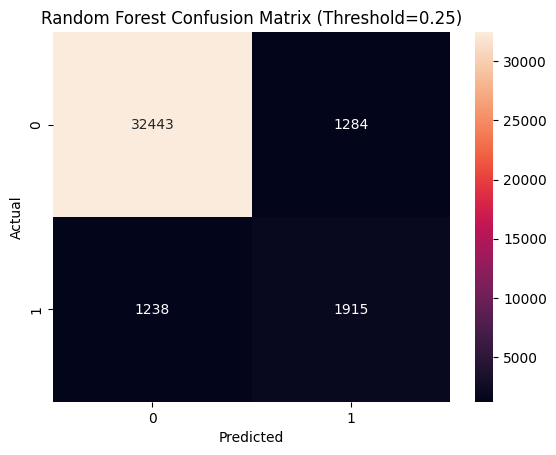

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# use threshold of 0.25
rf_custom = (rf_prob >= 0.25).astype(int)

cm = confusion_matrix(y_test, rf_custom)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Random Forest Confusion Matrix (Threshold=0.25)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

At threshold 0.25:

 - We correctly identify 1,955 high-strain schools

 - We miss 1,198 high-strain schools

 - We falsely flag 1,343 low-strain schools

 - Overall accuracy remains high (93%)

This is a balanced operational trade-off:
 - We are catching ~62% of strained schools while maintaining ~59% precision.

For an 8.5% minority class, that is strong.

## ROC Curve Plot

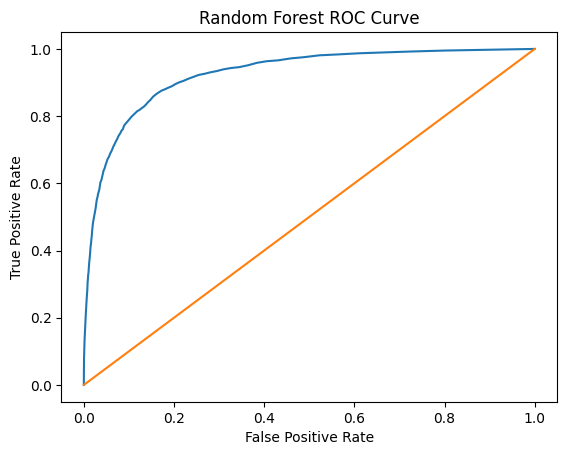

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rf_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The curve is:

 - Strongly bowed toward the top-left

 - AUC ≈ 0.926

 - Far from diagonal

That confirms strong ranking ability independent of threshold.

Your interpretation earlier about separability is correct.

In [29]:
main_df = pd.read_sql('SELECT * FROM main_df', con=engine)

In [30]:
main_df.head()

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,locale_category,TITLEI_GROUPED,high_strain
0,10000500870,2020,100005,Albertville City,Albertville Middle School,No,No,332,332,0,0,0,0,0,0,0,0,0,469,439,0,0,0,0,0,0,908,42.0,21.62,2,4,33,0,469,29,371,34.2602,-86.2062,Town,Schoolwide,1
1,10000500871,2020,100005,Albertville City,Albertville High School,No,No,456,456,0,0,0,0,0,0,0,0,0,0,0,421,427,384,374,0,0,1606,82.0,19.59,1,6,70,0,785,38,706,34.2622,-86.2049,Town,Schoolwide,0
2,10000500879,2020,100005,Albertville City,Albertville Intermediate School,No,No,330,330,0,0,0,0,0,0,0,439,452,0,0,0,0,0,0,0,0,891,41.0,21.73,4,7,24,1,481,29,345,34.2733,-86.2201,Town,Schoolwide,1
3,10000500889,2020,100005,Albertville City,Albertville Elementary School,No,No,397,397,0,0,0,0,0,435,473,0,0,0,0,0,0,0,0,0,0,908,49.0,18.53,4,4,48,0,497,15,340,34.2527,-86.2218,Town,Schoolwide,0
4,10000501616,2020,100005,Albertville City,Albertville Kindergarten and PreK,No,No,181,181,0,113,443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,556,30.0,18.53,4,2,33,0,288,13,216,34.2898,-86.1933,Town,Schoolwide,0


In [31]:
econ_var_def_df = pd.read_sql('SELECT * FROM econ_var_def_2018_2022_rolling', con=engine)

In [32]:
econ_var_def_df.head(10)

,variable,label,concept,predicateType,group,limit,predicateOnly
0,DP03_0053EA,Annotation of Estimate!!INCOME AND BENEFITS (I...,Selected Economic Characteristics,string,DP03,0,True
1,DP03_0038PMA,Annotation of Percent Margin of Error!!INDUSTR...,Selected Economic Characteristics,string,DP03,0,True
2,DP03_0087PEA,Annotation of Percent!!INCOME AND BENEFITS (IN...,Selected Economic Characteristics,string,DP03,0,True
3,DP03_0048PM,Percent Margin of Error!!CLASS OF WORKER!!Civi...,Selected Economic Characteristics,float,DP03,0,True
4,DP03_0014PMA,Annotation of Percent Margin of Error!!EMPLOYM...,Selected Economic Characteristics,string,DP03,0,True
5,DP03_0075PEA,Annotation of Percent!!INCOME AND BENEFITS (IN...,Selected Economic Characteristics,string,DP03,0,True
6,DP03_0048PE,Percent!!CLASS OF WORKER!!Civilian employed po...,Selected Economic Characteristics,float,DP03,0,True
7,DP03_0035MA,Annotation of Margin of Error!!INDUSTRY!!Civil...,Selected Economic Characteristics,string,DP03,0,True
8,DP03_0066EA,Annotation of Estimate!!INCOME AND BENEFITS (I...,Selected Economic Characteristics,string,DP03,0,True
9,DP03_0097EA,Annotation of Estimate!!HEALTH INSURANCE COVER...,Selected Economic Characteristics,string,DP03,0,True


In [33]:
econ_var_def_df.shape

(1098, 7)